In [1]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))
import healpy as h
from modules.flat_sky_codes import tangent_plane_analysis as tpa
from modules.flat_sky_codes import flat_sky_analysis as fsa
from modules.simulate.spatial_template import sim_cluster as sc
import collections
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
npix=256
pix_size=1.
d2x=((pix_size/60.)*np.pi/180.)**2.
d2k=1./(npix*npix*d2x)

# Construct the template bank

In [3]:
theta=np.linspace(5,40,20)
tmplt_bank=collections.OrderedDict()
tmplt_bank_ft=collections.OrderedDict()
for sz in theta:
    tmplt=sc.gen_cluster_template(npix,sz,pix_size,y0=1e-4)
    tmplt_bank[sz]=tmplt
    tmplt_bank_ft[sz]=fsa.map2alm(np.fft.fftshift(tmplt/1e-4),pix_size)

In [184]:
def return_mf_snr(data):
    data_ft=fsa.map2alm(data,pix_size)
    avg_ell,avg_Cl=fsa.alm2cl(data_ft,pixel_size=pix_size,smwin=15)
    # avg_Cl=avg_Cl/(d2x*npix*npix)
    Pk=fsa.get_fourier_filter(avg_Cl,npix,pixel_size=pix_size,ell=avg_ell)
    
    snr=collections.OrderedDict()
    snr[0]=collections.OrderedDict()
    theta_true={}
    mf_data={}
    mf_data[0]={}
    for sz in tmplt_bank_ft.keys():
        template_ft=tmplt_bank_ft[sz]
        norm=np.sum(np.conj(template_ft)*template_ft/Pk)*d2k ; err=np.sqrt(1./abs(norm))
        mf=(np.conj(template_ft)/Pk)/norm
        mf_data[0][sz]=fsa.alm2map(mf*data_ft,pix_size)
        snr[0][sz]=max(mf_data[0][sz].ravel())/err
        
    idx=np.where(max(snr[0].values())==snr[0].values())[0][0]
    theta_true[0]=snr[0].keys()[idx]
    amp=np.max(mf_data[0][theta_true[0]].ravel())
    tmplt=sc.gen_cluster_template(npix,sz,pix_size,y0=amp)
    
    Pk_data_ft=fsa.map2alm(data-tmplt,pix_size)
    avg_ell,avg_Cl=fsa.alm2cl(Pk_data_ft,pixel_size=pix_size,smwin=15)
    # avg_Cl=avg_Cl/(d2x*npix*npix)
    Pk=fsa.get_fourier_filter(avg_Cl,npix,pixel_size=pix_size,ell=avg_ell)
    
    snr[1]=collections.OrderedDict()
    mf_data[1]={}
    for sz in tmplt_bank_ft.keys():
        template_ft=tmplt_bank_ft[sz]
        norm=np.sum(np.conj(template_ft)*template_ft/Pk)*d2k ; err=np.sqrt(1./abs(norm))
        mf=(np.conj(template_ft)/Pk)/norm
        mf_data[1][sz]=fsa.alm2map(mf*data_ft,pix_size)
        snr[1][sz]=max(mf_data[1][sz].ravel())/err
        
    idx=np.where(max(snr[0].values())==snr[0].values())[0][0]
    theta_true[1]=snr[1].keys()[idx]
    
    return snr,mf_data,theta_true

In [4]:
def return_mf_snr(data):
    data_ft=fsa.map2alm(data,pix_size)
    avg_ell,avg_Cl=fsa.alm2cl(data_ft,pixel_size=pix_size,smwin=15)
#     avg_Cl=avg_Cl/(d2x*npix*npix)
    Pk=fsa.get_fourier_filter(avg_Cl,npix,pixel_size=pix_size,ell=avg_ell)
    
    snr=collections.OrderedDict()
    mf_data={}
    err=collections.OrderedDict()
    for sz in tmplt_bank_ft.keys():
        template_ft=tmplt_bank_ft[sz]
        norm=np.sum(np.conj(template_ft)*template_ft/Pk)*d2k ; err[sz]=np.sqrt(1./abs(norm))
        mf=(np.conj(template_ft)/Pk)/norm
        mf_data[sz]=fsa.alm2map(mf*data_ft,pix_size)
        snr[sz]=max(mf_data[sz].ravel())/err[sz]
        
    idx=np.where(max(snr.values())==snr.values())[0][0]
    theta_true=snr.keys()[idx]
    
    return snr,err,mf_data,theta_true

In [9]:
theta0=theta[2] ; print theta0
theta_dist=[]
err_dist={}
snr_dist={}
nrlz=1
for i in range(nrlz):
    data=tmplt_bank[theta0] + np.random.normal(0,4.e-5,(npix,npix))
    snr,err,mf_map,temp=return_mf_snr(data)
    err_dist[i]=err
    snr_dist[i]=snr
    theta_dist=theta_dist + [temp]
    
# figure()
# imshow(data)

8.68421052631579


<IPython.core.display.Javascript object>


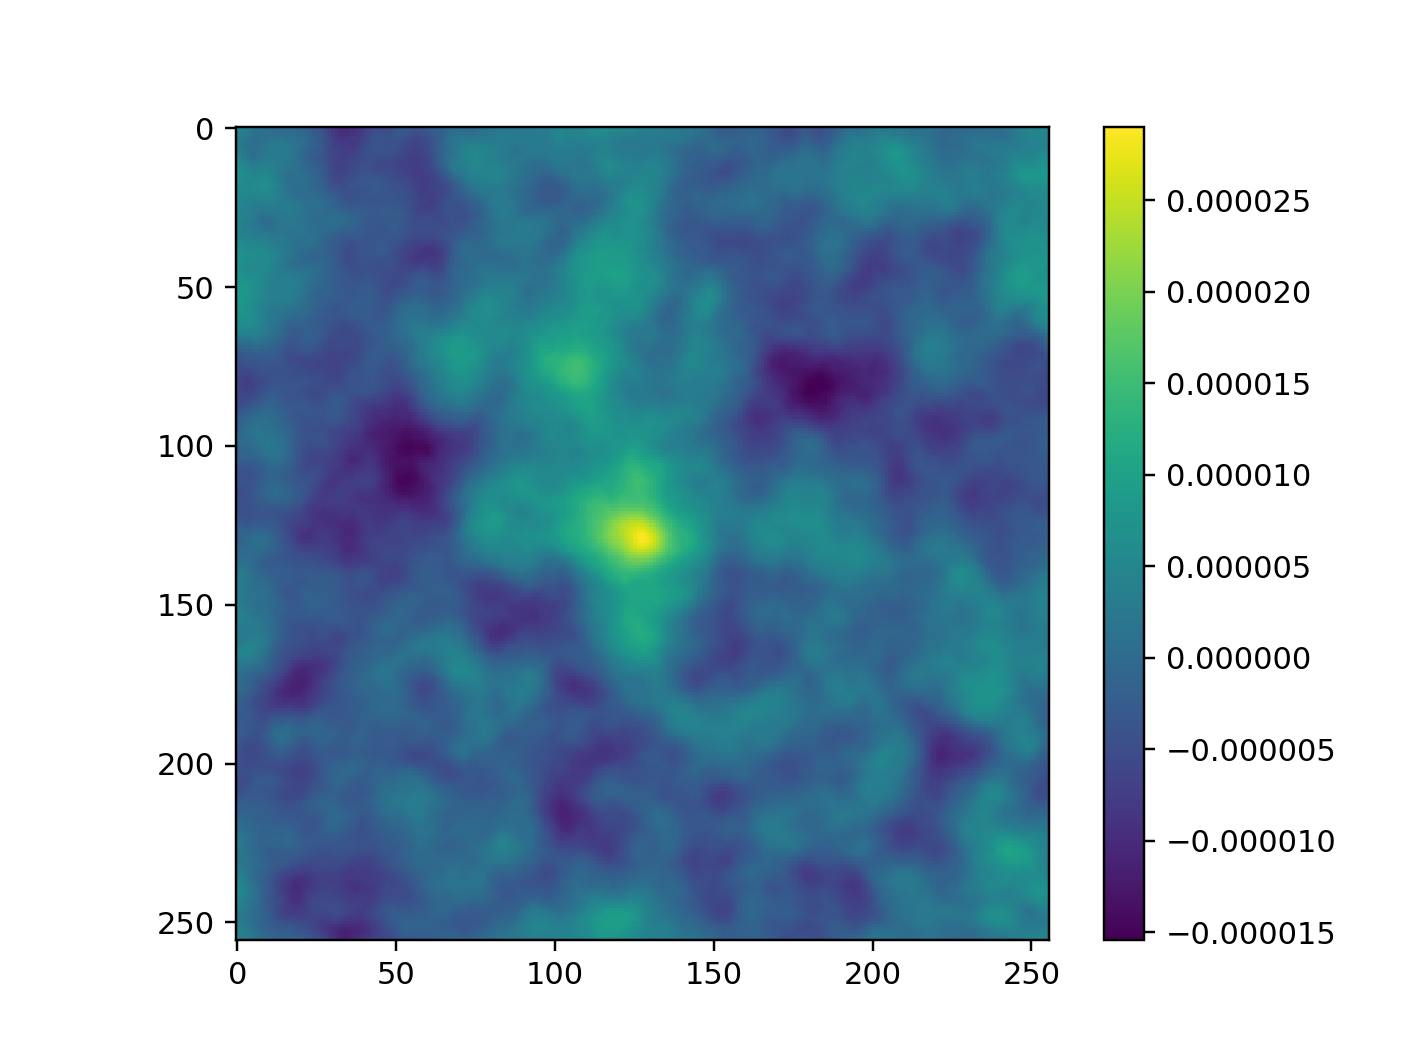

In [12]:
figure()
imshow(mf_map[theta[12]])
colorbar()

<IPython.core.display.Javascript object>


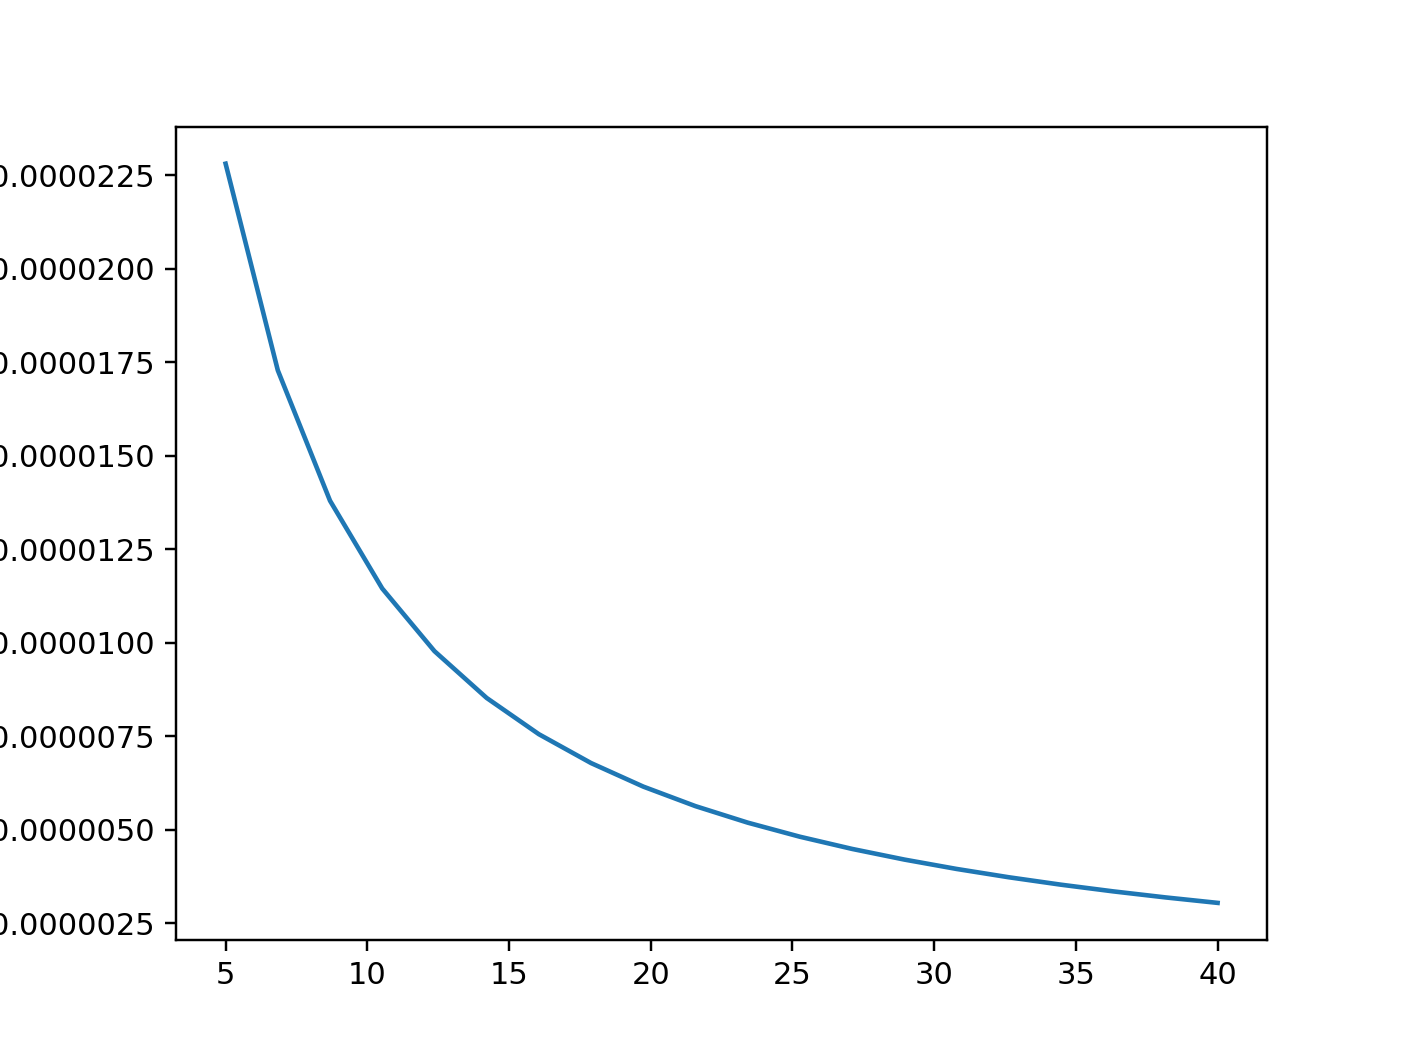

<IPython.core.display.Javascript object>


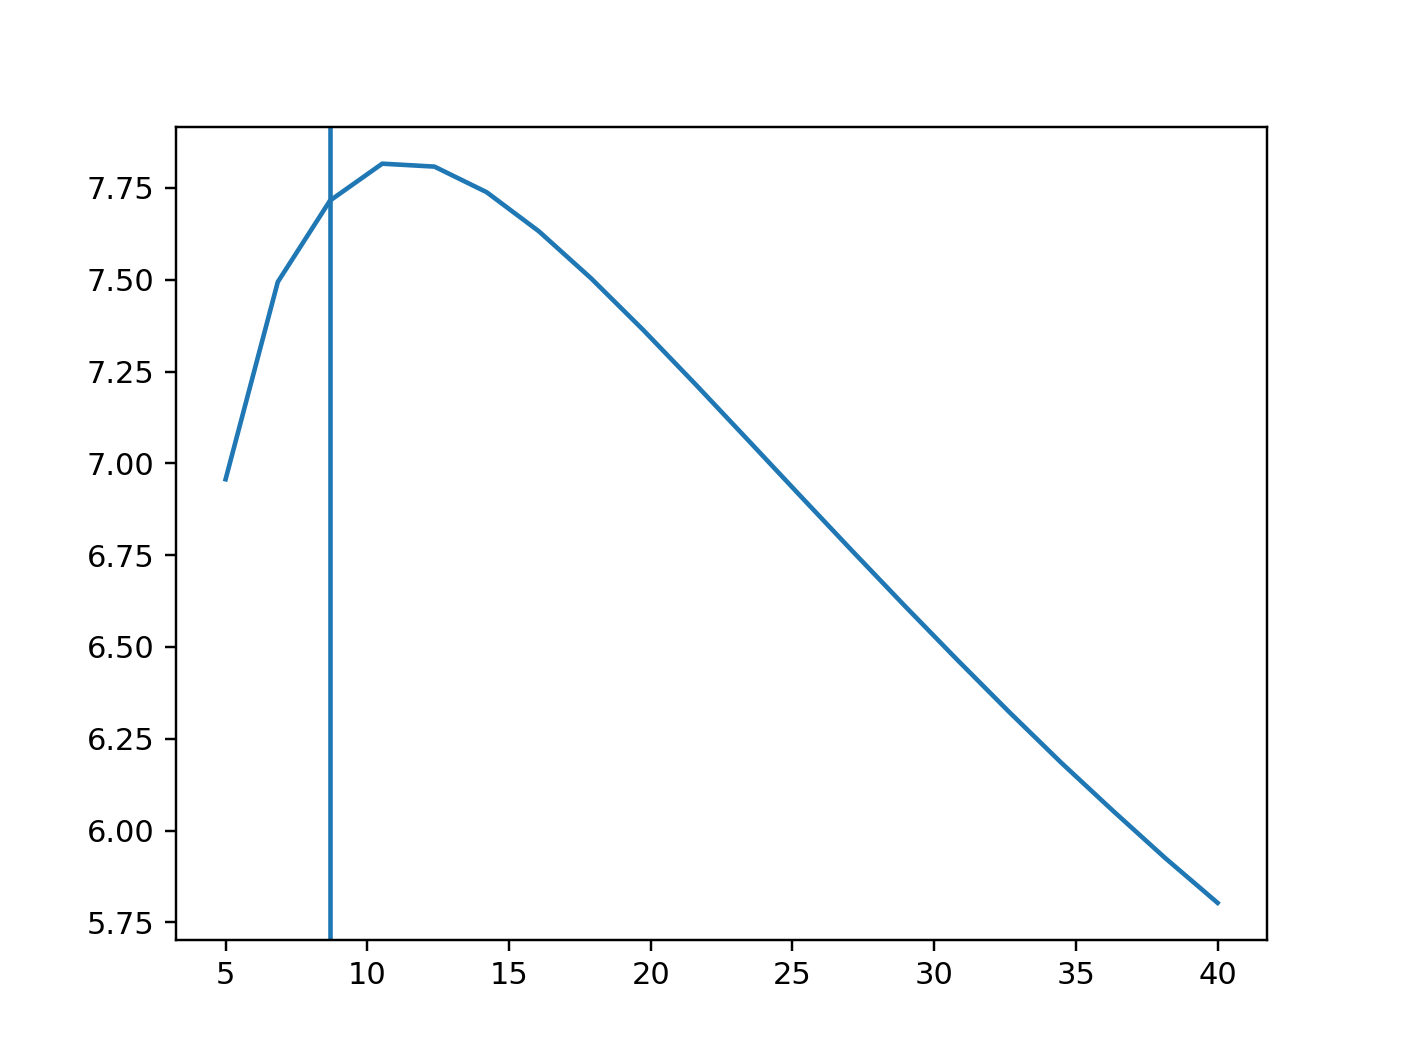

In [699]:
figure()
for i in range(nrlz):
    plot(theta,err_dist[i].values())
    
figure()
for i in range(nrlz):
    plot(theta,snr_dist[i].values())
axvline(theta0)

In [700]:
data_ft=fsa.map2alm(data,pix_size)
avg_ell,avg_Cl=fsa.alm2cl(data_ft,pixel_size=pix_size,smwin=15)
Pk=fsa.get_fourier_filter(avg_Cl,npix,pixel_size=pix_size,ell=avg_ell)
ttp=collections.OrderedDict()
ttp_ft_bank=collections.OrderedDict()
for i,th in enumerate(theta):
    template_ft=tmplt_bank_ft[th]
    norm=np.sum(np.conj(template_ft)*template_ft/Pk)*d2k
    mf=(np.conj(template_ft)/Pk)/norm
    ttp[th]=collections.OrderedDict()
    ttp_ft_bank[th]=collections.OrderedDict()
    for j,thp in enumerate(theta[theta>=th]):    
        ttp[th][thp]=fsa.alm2map(mf*fsa.map2alm(tmplt_bank[thp],pix_size),pix_size)
        ttp_ft_bank[th][thp]=fsa.map2alm(np.fft.fftshift(ttp[th][thp]),pix_size)

In [701]:
def return_mf_2o(mf_maps):
    snr=collections.OrderedDict()
    mf_data_2o=collections.OrderedDict()
    for th in sorted(mf_maps.keys()):
        data_ft=fsa.map2alm(mf_maps[th],pix_size)
        avg_ell,avg_Cl=fsa.alm2cl(data_ft,pixel_size=pix_size,smwin=15)
        # avg_Cl=avg_Cl/(d2x*npix*npix)
        Pk=fsa.get_fourier_filter(avg_Cl,npix,pixel_size=pix_size,ell=avg_ell)
        mf_data_2o[th]=collections.OrderedDict()
        snr[th]=collections.OrderedDict()
        for j,thp in enumerate(theta[theta>=th]):    
            template_ft=ttp_ft_bank[th][thp]
            norm=np.sum(np.conj(template_ft)*template_ft/Pk)*d2k ; err=np.sqrt(1./abs(norm))
            mf=(np.conj(template_ft)/Pk)/norm
            mf_data_2o[th][thp]=fsa.alm2map(mf*data_ft,pix_size)
            snr[th][thp]=max(mf_data_2o[th][thp].ravel())/err
        
    return snr,mf_data_2o

In [702]:
snr2o,mf_map_2o=return_mf_2o(mf_map)

In [703]:
snr_map=np.zeros((len(snr2o.keys()),len(snr2o.keys())),np.float64)
for i, th in enumerate(snr2o.keys()):
    for j, thp in enumerate(snr2o[th].keys()):
        idx1=np.where(theta==th)[0][0]
        idx2=np.where(theta==thp)[0][0]
#         print idx1, idx2
        snr_map[idx1,idx2]=snr2o[th][thp]
        snr_map[idx2,idx1]=snr_map[idx1,idx2]

<IPython.core.display.Javascript object>


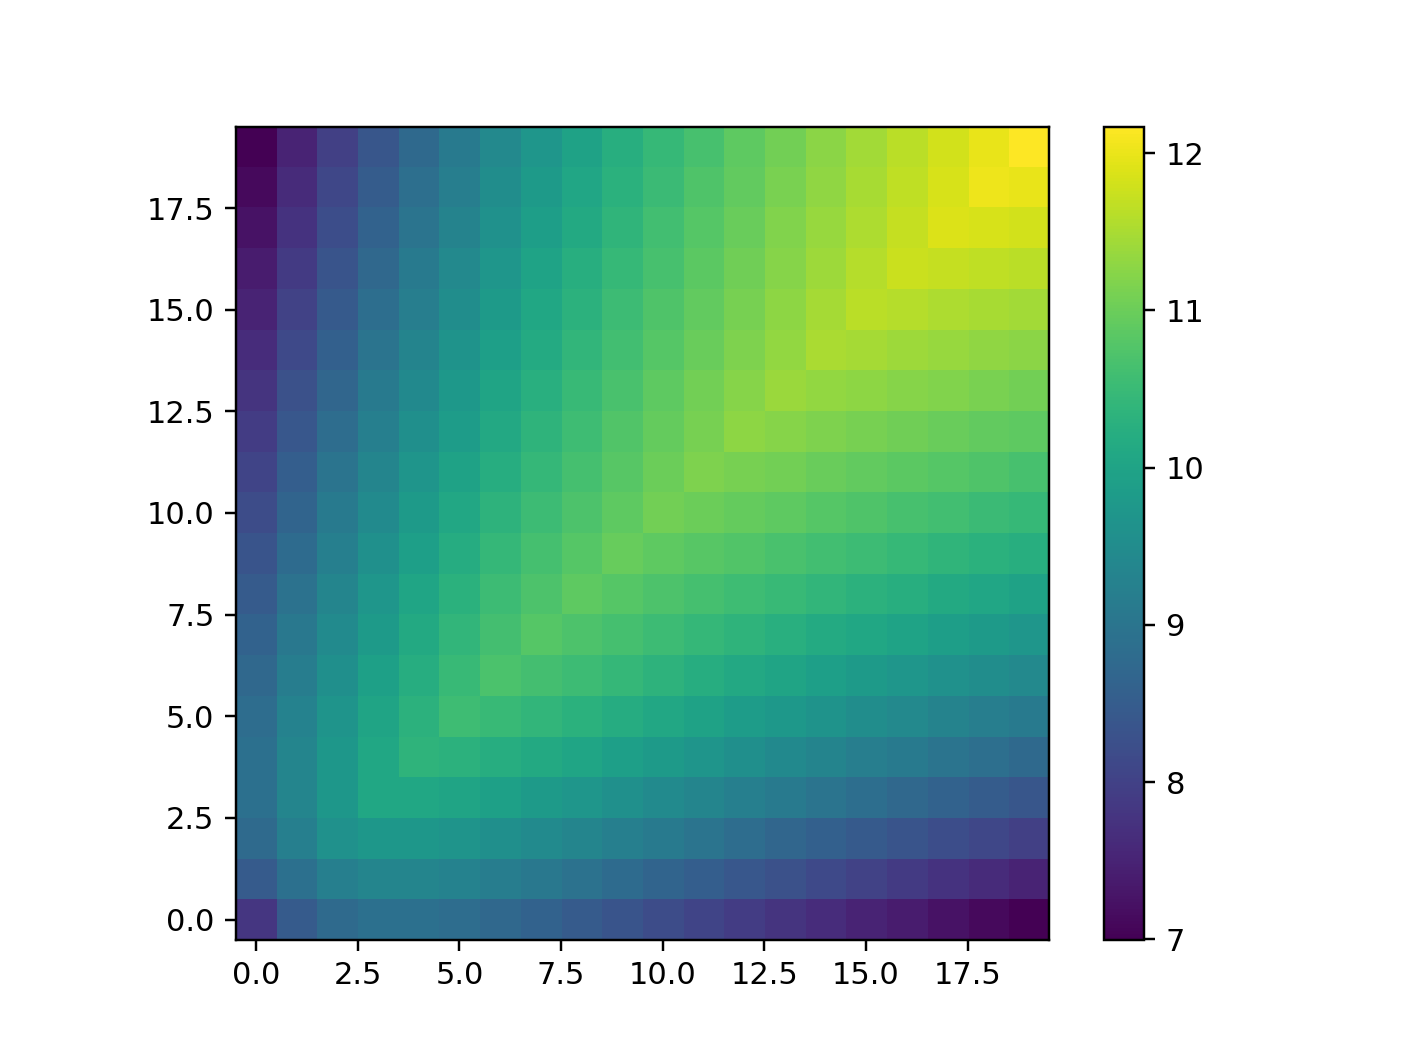

In [704]:
figure()
imshow(snr_map,origin="lower")
colorbar()

In [705]:
dsnr=np.diag(snr_map)
theta[np.where(dsnr==max(dsnr))[0][0]],theta[np.where(snr.values()==max(snr.values()))[0][0]],theta0

(40.0, 10.526315789473685, 8.68421052631579)

<IPython.core.display.Javascript object>


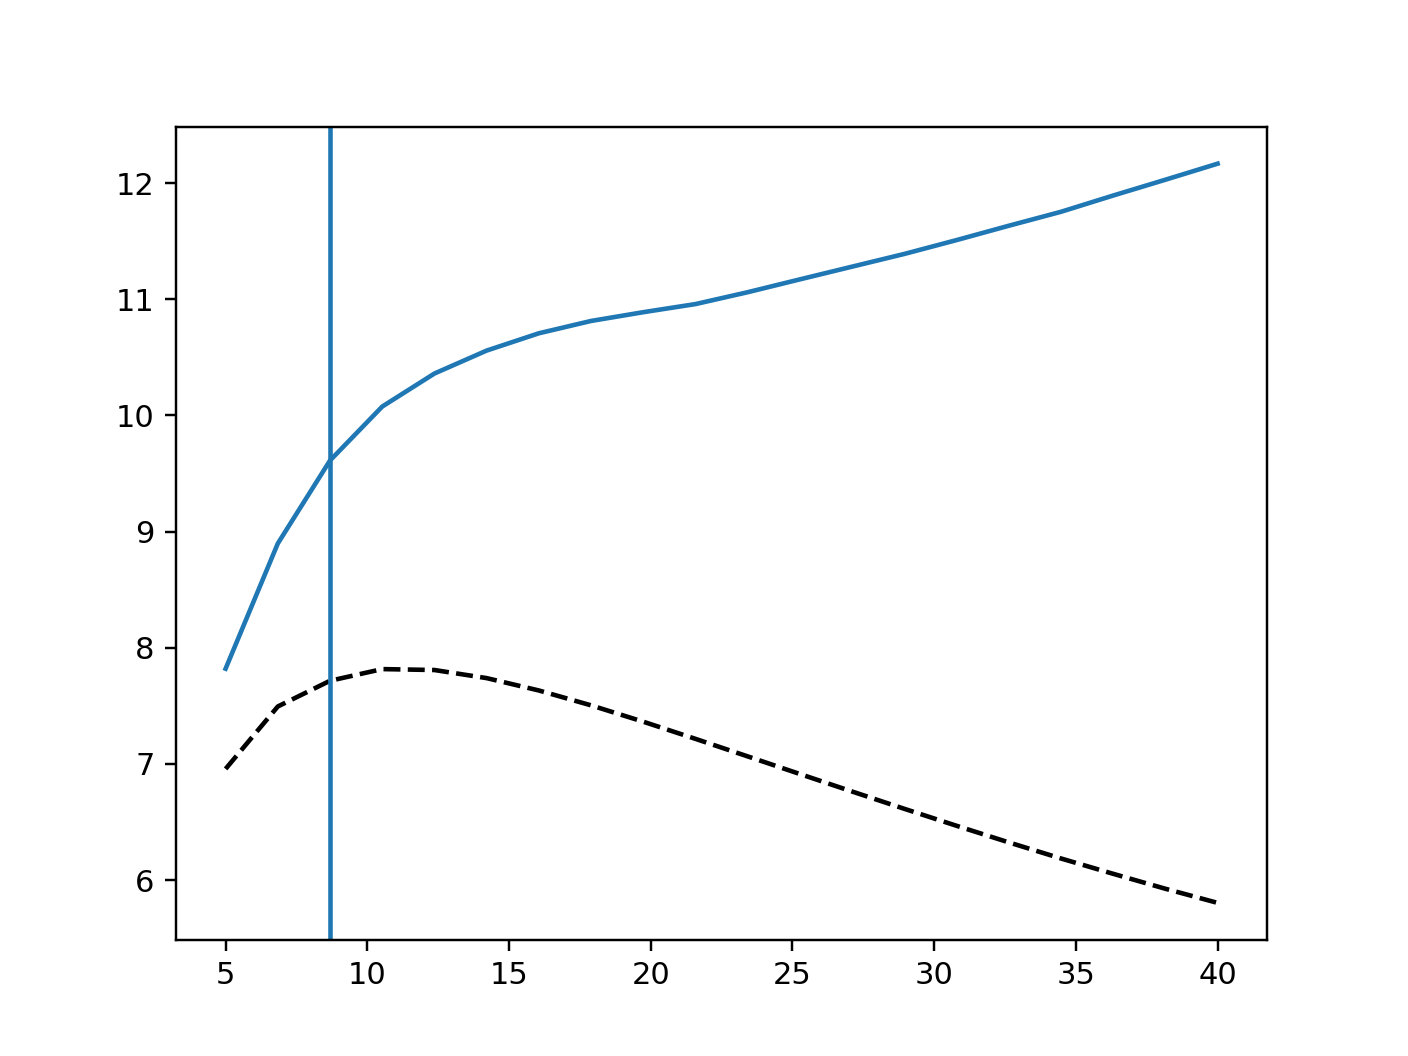

In [706]:
figure()
plot(theta,np.diag(snr_map))
plot(theta,snr.values(),"k--")
axvline(theta0)

<IPython.core.display.Javascript object>


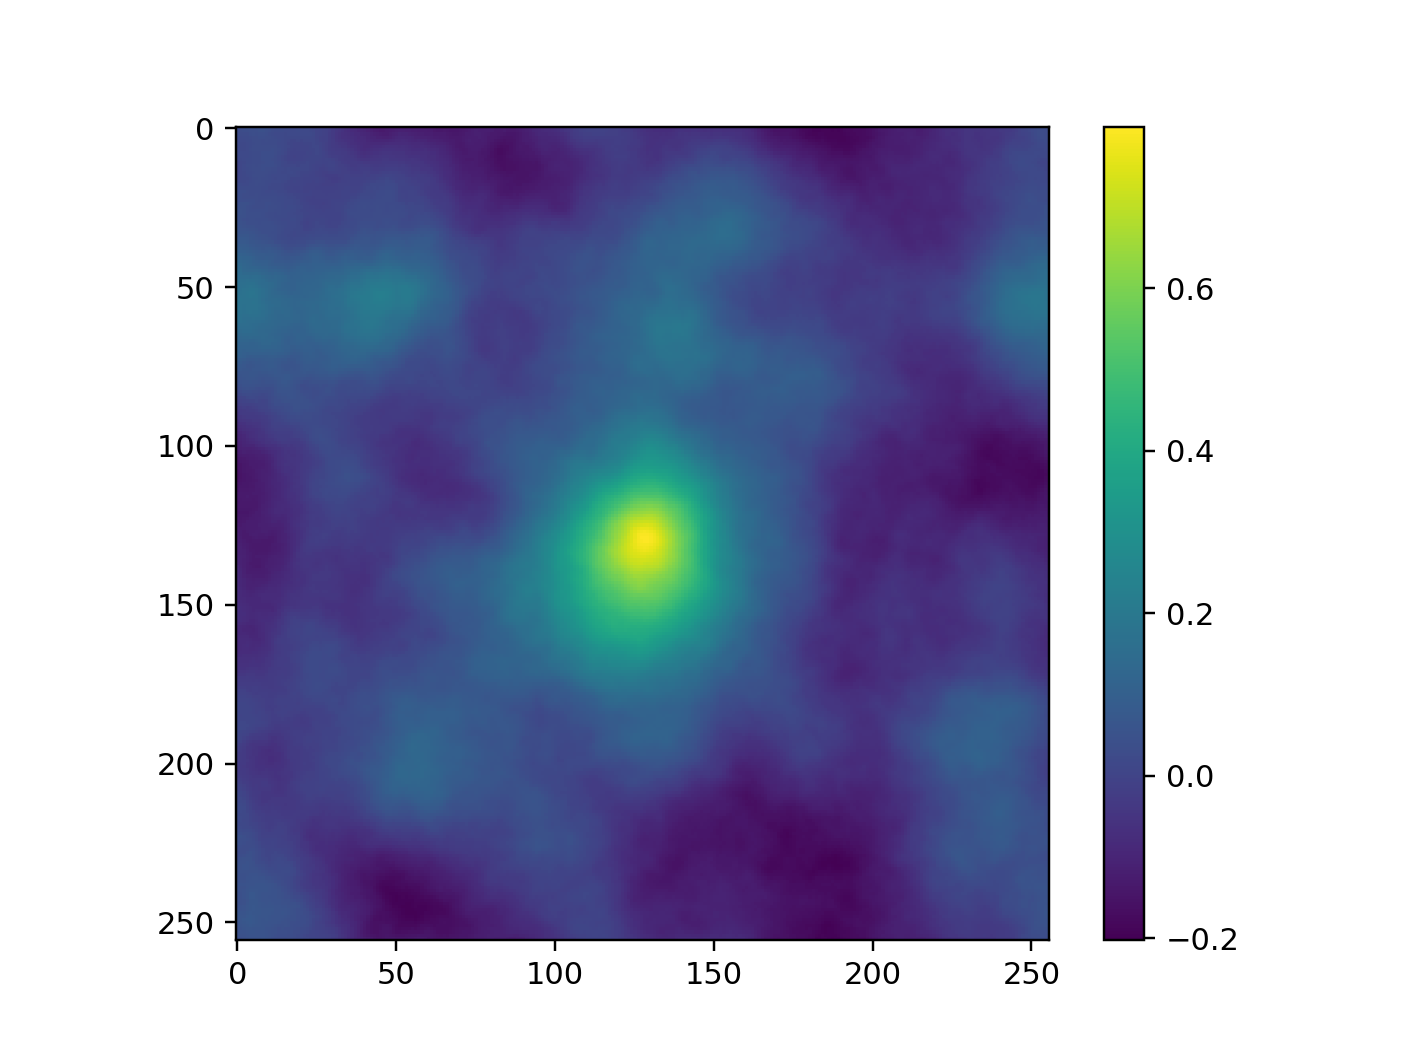

<IPython.core.display.Javascript object>


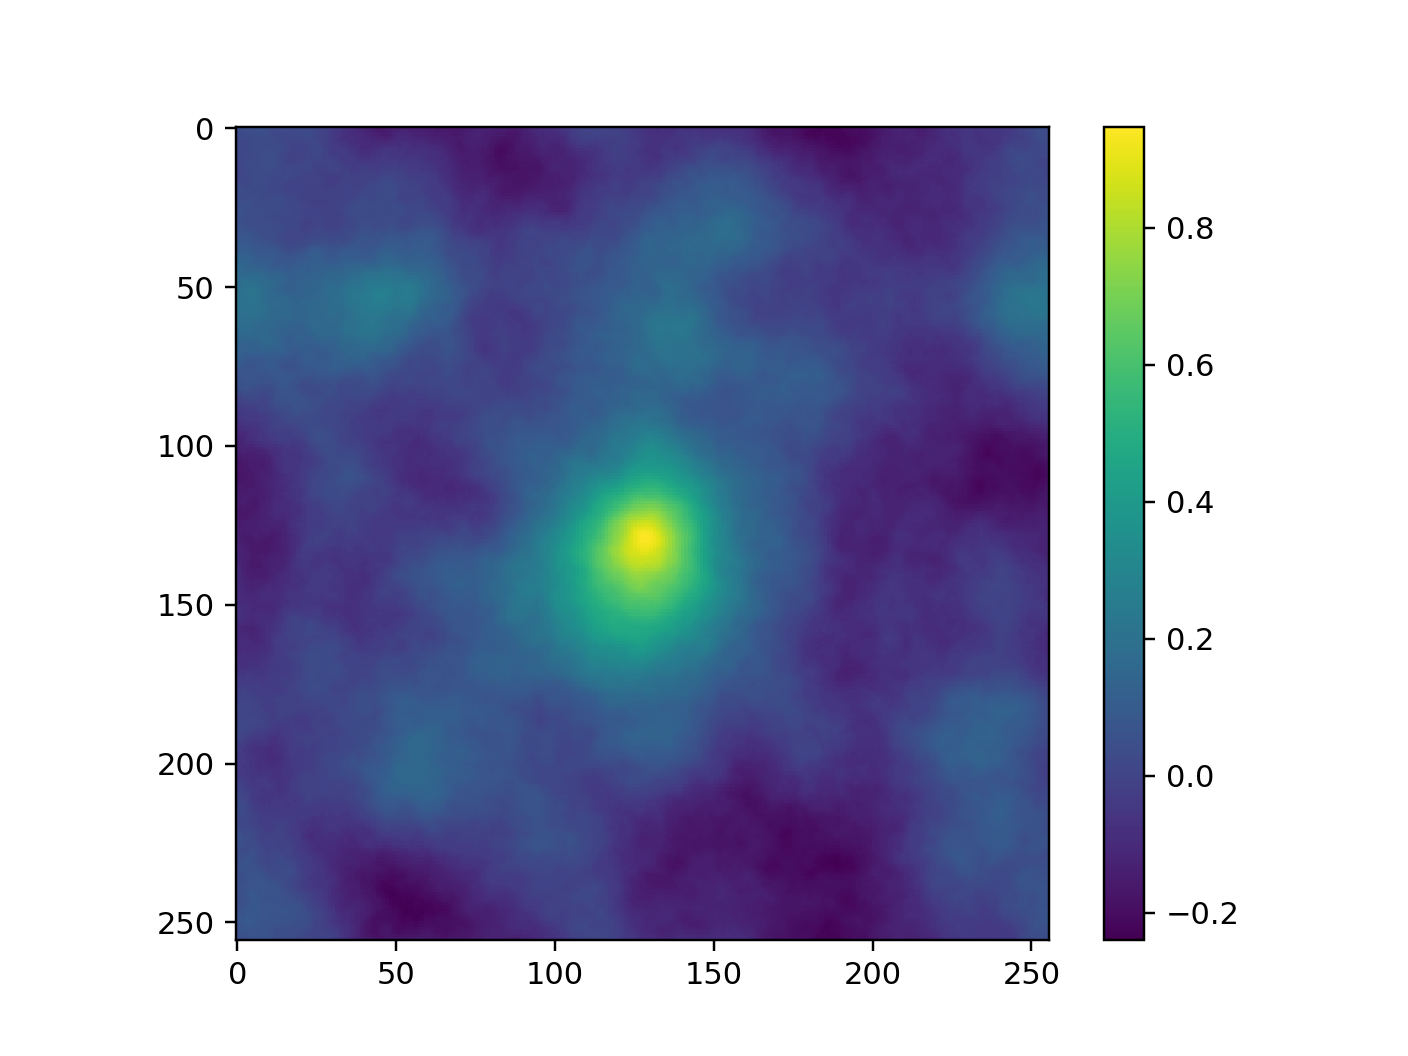

<IPython.core.display.Javascript object>


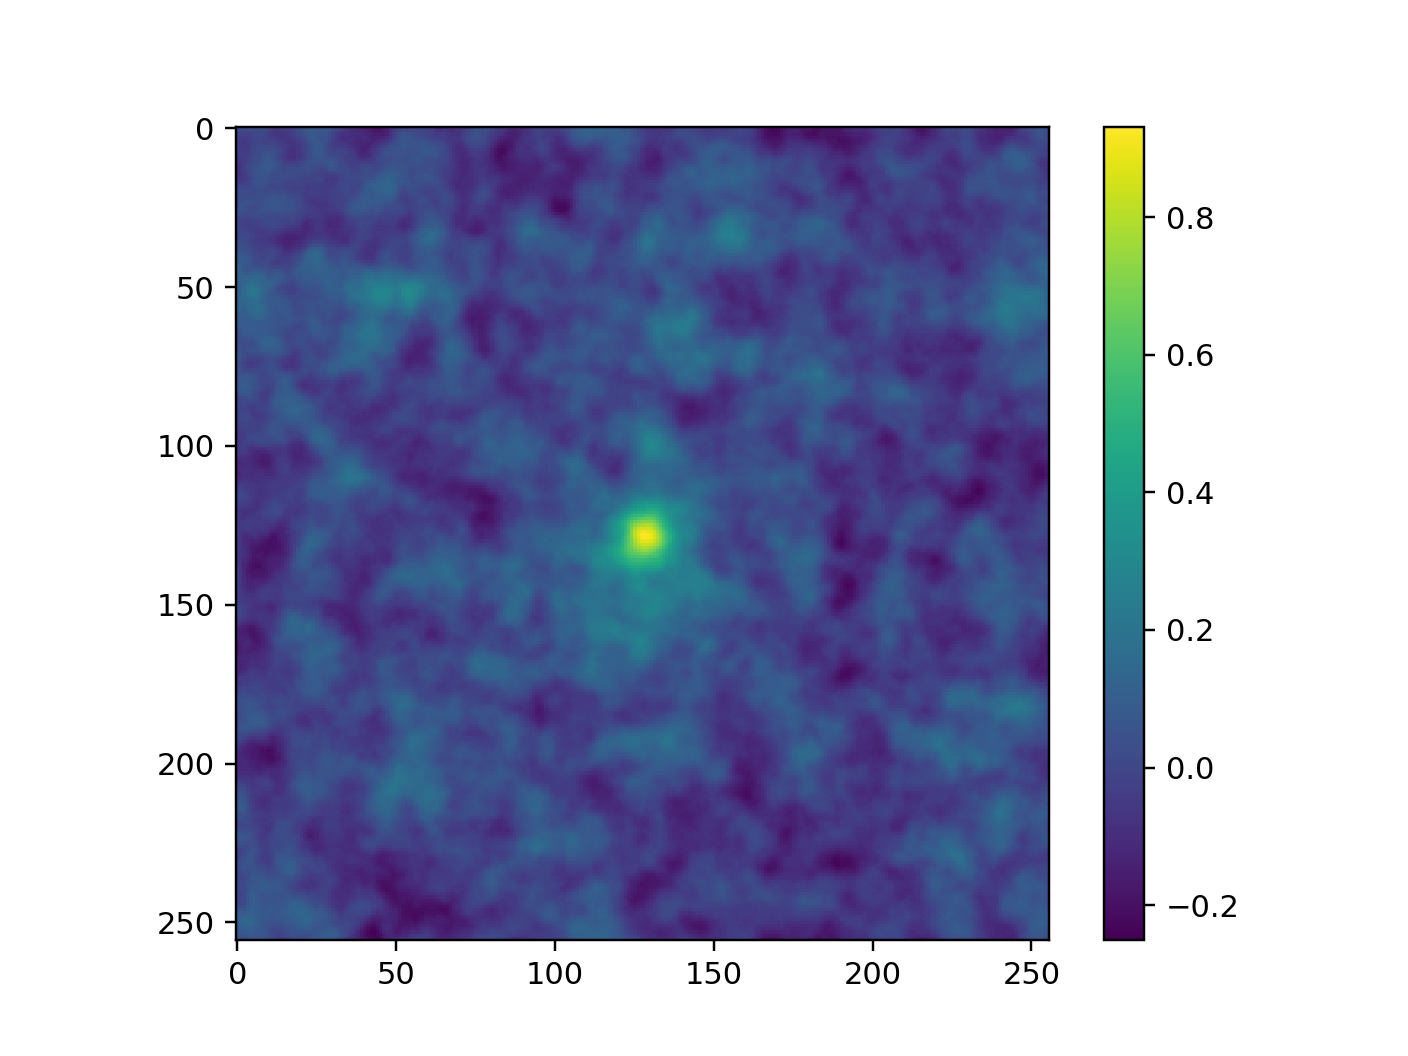

In [621]:
idx=5
figure()
imshow(mf_map_2o[theta[idx]][theta[idx+1]])
colorbar()

figure()
imshow(mf_map_2o[theta[idx]][theta[idx]])
colorbar()

figure()
imshow(mf_map[theta[idx]])
colorbar()

In [13]:
2.625**2

6.890625